### PCAM Eksperymenty - Seria 1

### Wspólne

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.append("../..")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset, Dataset, DataLoader
from torcheval.metrics.functional import multiclass_f1_score, multiclass_accuracy
import torchvision.transforms as T

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import src.modules.data_module as dm
import src.modules.learner_module as lm
import src.modules.evaluation_module as em
import src.modules.pipeline as pp

import src.models as models

dm.update_data_dir('../../data')
device = (
    "cuda" if torch.cuda.is_available() else "cpu"
)
print(f"Using {device} device")

Default data directory set to c:\MyRoot\PWFiles\semestr 6\WB\wb-active-learning\notebooks\common\data
To change this path, use the update_data_dir() function from the data_module
Initialising Lazy Loader (PCAMLL)
Data directory set to: c:\MyRoot\PWFiles\semestr 6\WB\wb-active-learning\data
Using cuda device


### Jasiek
- `N`: 5
- `init`: 500
- `query_batch_size`: 500
- `n_queries`: 19
- `unlabeled_size`: 50_000

In [ ]:
N = 5
settings = pp.PipelineSettings(19, 50, 50, 500, 'confidence')
train_size = 50_000
ratio_labeled = 0.01
test_size = 5000
loss_fn = F.cross_entropy

### Maciek
- `N`: 5
- `init`: 500
- `query_batch_size`: 100
- `n_queries`: 45
- `unlabeled_size`: 50_000

In [ ]:
N = 5
settings = pp.PipelineSettings(45, 50, 50, 100, 'confidence')
train_size = 50_000
ratio_labeled = 0.01
test_size = 5000
loss_fn = F.cross_entropy

### Szymon
- `N`: 5
- `init`: 100
- `query_batch_size`: 100
- `n_queries`: 49
- `unlabeled_size`: 50_000

In [ ]:
N = 5
settings = pp.PipelineSettings(49, 50, 50, 100, 'confidence')
train_size = 50_000
ratio_labeled = 0.002
test_size = 5000
loss_fn = F.cross_entropy

### Wiktor
- `N`: 3
- `init`: 500
- `query_batch_size`: 500
- `n_queries`: 39
- `unlabeled_size`: 50_000

In [6]:
N = 3
settings = pp.PipelineSettings(39, 50, 50, 500, 'confidence')
train_size = 50_000
ratio_labeled = 0.01
test_size = 5000
loss_fn = F.cross_entropy

### Test (Ignore)

In [3]:
N = 1
settings = pp.PipelineSettings(3, 50, 50, 500, 'confidence')
train_size = 10_000
ratio_labeled = 0.05
test_size = 1000
loss_fn = F.cross_entropy

### Wspólne (Oprócz Sebastiana)

In [6]:
evaluation = em.Evaluation(262144)
for i in range(N):
    print(f"trial: {i + 1}")
    
    model = models.PCAMClassifierSmall().to(device)
    learner = lm.ActiveLearner(model, device)
    optimizer = torch.optim.Adam(params=model.parameters())

    dataset = dm.ActiveDataset('pcam', train_size, test_size, ratio_labeled=ratio_labeled, balanced_split=False)
    pipeline = pp.Pipeline(dataset, learner, optimizer, loss_fn, settings)
    session, stats = pipeline.run(verbose=1, calculate_accuracy=True)
    evaluation.append(session)

trial: 1
Iteration: 1
Iteration: 2
Iteration: 3


In [22]:
stats

{'t_loss_history': [0.6604787576943636,
  0.5646756310015917,
  0.5395107381045818,
  0.4869495201855898,
  0.44578016363084316,
  0.3925765510648489,
  0.3962420839816332,
  0.2772591793909669,
  0.1770090633071959,
  0.16618593269959092,
  0.5907770441845059,
  0.5353318369016051,
  0.4740642225369811,
  0.42378219682723284,
  0.3496539741754532,
  0.2446841518394649,
  0.17900431901216507,
  0.1446740715764463,
  0.13421180087607354],
 'v_loss_history': [0.6402731314301491,
  0.7902173548936844,
  0.5355012491345406,
  0.641561709344387,
  0.48961926624178886,
  0.5998539999127388,
  0.677541583776474,
  0.6364129930734634,
  0.643676333129406,
  1.1688323765993118,
  0.574190903455019,
  0.5638282112777233,
  0.7467082515358925,
  0.5611105933785439,
  0.7505740970373154,
  0.7822552397847176,
  0.6768268346786499,
  0.7156452387571335,
  1.0535659193992615],
 'accuracy_history': [0.7549999952316284, 0.7540000081062317],
 'f1score_history': []}

In [15]:
evaluation.top_queried(1)

array([94])

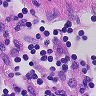

In [21]:
T.ToPILImage()(dataset._full_train_set[94][0])

### Sebastian